In [1]:
import cv2
from utils import get_train_raw_dataset, polyp_size, rotate
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import albumentations as A
import colortrans
np.random.seed(0)

In [2]:
ds = get_train_raw_dataset()

# mixblur

In [3]:
def mixblur(img1, gt1, img2, gt2):
    """
    Resize source to match destination. Then copy polyp from source and paste to destination.
    
    Params:
        img1, gt1: destination
        img2, gt2: source
    """
    height, width = img1.shape[0], img1.shape[1]
    img2 = cv2.resize(img2, dsize=(width, height))
    gt2 = cv2.resize(gt2, dsize=(width, height))

    # Blend img
    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(gt2, kernel, iterations = 10)
    mask = cv2.blur(dilation / 255, (50, 50))
    mask = np.stack((mask, mask, mask), axis=2)
    img_ret = img2 / 255 * mask + img1 / 255 * (1-mask)

    # Combine gt
    gt_ret = gt2 | gt1

    # Convert to 0-255
    img_ret = np.clip(img_ret, 0, 1)
    img_ret = (img_ret * 255).astype('uint8')
    gt_ret = np.clip(gt_ret, 0, 1)
    gt_ret = (gt_ret * 255).astype('uint8')

    return img_ret, gt_ret

test mixblur function

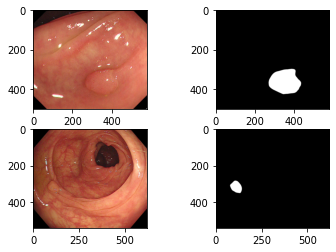

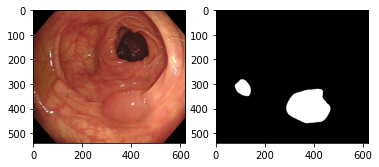

In [4]:
img_idx1 = 147
img1 = ds.get_img(ds_name='SunDataset', img_idx=img_idx1)
gt1 = ds.get_gt(ds_name='SunDataset', img_idx=img_idx1)
img_idx2 = 189
img2 = ds.get_img(ds_name='SunDataset', img_idx=img_idx2)
gt2 = ds.get_gt(ds_name='SunDataset', img_idx=img_idx2)

plt.subplot(221), plt.imshow(img1[:,:,::-1])
plt.subplot(222), plt.imshow(gt1, cmap='gray')
plt.subplot(223), plt.imshow(img2[:,:,::-1])
plt.subplot(224), plt.imshow(gt2, cmap='gray')
plt.show()

img_ret, gt_ret = mixblur(img2, gt2, img1, gt1)
plt.subplot(121), plt.imshow(img_ret[:,:,::-1])
plt.subplot(122), plt.imshow(gt_ret, cmap='gray')
plt.show()

In [5]:
def intersect(gt1, gt2):
    height, width = gt1.shape[0], gt1.shape[1]
    gt2_resize = cv2.resize(gt2, dsize=(width, height))
    return np.sum(gt2_resize & gt1) > 0

In [6]:
SAVE_ROOT = './dataset/MixBlur'

# Remove and create directory
img_save_dir = os.path.join(SAVE_ROOT, "images")
gt_save_dir = os.path.join(SAVE_ROOT, "masks")
shutil.rmtree(SAVE_ROOT, ignore_errors=True)
os.makedirs(img_save_dir)
os.makedirs(gt_save_dir)

def do():
    j = 0
    for ds_name in ['TrainDataset', 'SunDataset']:
        print("Process", ds_name)

        n_imgs = len(ds.filenames[ds_name])
        for i in range(n_imgs):
            filename = ds.filenames[ds_name][i]
            img1 = ds.get_img(ds_name, i)
            gt1 = ds.get_gt(ds_name, i)

            if polyp_size(gt1) > 5:
                continue

            contours, hier = cv2.findContours(gt1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if len(contours) > 1:
                continue
            
            while True:
                # Choose a background
                if np.random.rand() > 0.5:
                    ds_name2 = 'SunDataset'
                else:
                    ds_name2 = 'TrainDataset'
                ds_name2 = np.random.choice(['SunDataset', 'TrainDataset'])
                img_idx2 = np.random.choice(len(ds.filenames[ds_name2]) - 1)
                img2 = ds.get_img(ds_name2, img_idx2)
                gt2 = ds.get_gt(ds_name2, img_idx2)

                if polyp_size(gt2) > 5:
                    continue

                # Color transfer
                # img1 = colortrans.transfer_reinhard(img1, img2)
                img1 = colortrans.transfer_lhm(img1, img2)
                
                # Rotate
                M = cv2.moments(contours[0])
                if M['m00'] == 0:
                    continue
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                angle = np.random.randint(0, 360)
                img1 = rotate(img1, angle, (cx, cy))
                gt1 = rotate(gt1, angle, (cx, cy))

                # Flip
                trans = A.Flip()
                res = trans(image=img1, mask=gt1)
                img1, gt1 = res['image'], res['mask']
                
                # Resize polyp
                # TODO

                # Choose a random background img

                # Check intersect
                if intersect(gt1, gt2):
                    continue

                # Paste polyp
                img_mix, gt_mix = mixblur(img2, gt2, img1, gt1)
                
                # Save
                fn1 = filename
                fn2 = ds.filenames[ds_name2][img_idx2]
                fn = f"{j}.{fn1}.blurmix.{fn2}.png"
                cv2.imwrite(os.path.join(img_save_dir, fn), img_mix)
                cv2.imwrite(os.path.join(gt_save_dir, fn), gt_mix)

                # cv2.imshow("imsh", np.stack((img, img1, img2)))
                # if cv2.waitKey(0) & 0xFF == 27:
                #     return

                j += 1

                break

            if i % 10 == 0:
                print(f"Img {i}/{n_imgs}")
                
do()
cv2.destroyAllWindows()

Process TrainDataset
Img 50/1450
Img 80/1450
Img 110/1450
Img 170/1450
Img 180/1450
Img 250/1450
Img 260/1450
Img 290/1450
Img 330/1450
Img 340/1450
Img 400/1450
Img 410/1450
Img 510/1450
Img 520/1450
Img 530/1450
Process SunDataset
Img 0/983
Img 60/983
Img 70/983
Img 80/983
Img 90/983
Img 100/983
Img 110/983
Img 120/983
Img 130/983
Img 150/983
Img 160/983
Img 170/983
Img 210/983
Img 220/983
Img 260/983
Img 270/983
Img 330/983
Img 370/983
Img 380/983
Img 390/983
Img 400/983
Img 410/983
Img 450/983
Img 480/983
Img 490/983
Img 520/983
Img 540/983
Img 550/983
Img 560/983
Img 590/983
Img 600/983
Img 610/983
Img 620/983
Img 680/983
Img 700/983
Img 710/983
Img 720/983
Img 730/983
Img 810/983
Img 820/983
Img 830/983
Img 840/983
Img 850/983
Img 880/983
Img 900/983
Img 910/983
Img 970/983
Img 980/983
